## <font color='purple'> About Pneumonia </font>

Pneumonia is a medical condition characterized by inflammation of the air sacs in one or both lungs. These air sacs, called alveoli, may fill with fluid or pus, causing symptoms such as cough, fever, chills, and difficulty breathing. Pneumonia can be caused by various pathogens, including bacteria, viruses, fungi, and parasites. It can range from mild to severe and can be particularly dangerous for young children, the elderly, and individuals with weakened immune systems. Treatment usually involves antibiotics for bacterial pneumonia, antiviral medications for viral pneumonia, and supportive care to alleviate symptoms and help the body fight the infection. Vaccines are available to prevent certain types of pneumonia, such as those caused by the bacteria Streptococcus pneumoniae and the influenza virus.

<img src="https://www.h-h-c.com/wp-content/uploads/2021/08/Lobar-Pneumonia.png.webp" />

## <font color ='purple'>Importing the necessary Libraries </font>

In [ ]:
!pip install torchinfo

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

import csv
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchinfo import summary as torch_summary

## <font color ='purple'>Describe about Dataset </font>

- **Structure**: The dataset is organized into 3 folders (train, test, val).
- **Quantity**: There are 5,863 X-Ray images (JPEG) and 2 categories (Pnenumonial/Normal)
- **Origin**: Anterior-posterior chest X-ray images were obtained from Guangzhou Women and Children’s Medical Center in Guangzhou.
- **Quality**: An initial quality control process was conducted to exclude any scans of poor quality or illegible.

## <font color ='purple'>Loading Dataset</font>

In [ ]:
# !rm -rf 'x-ray-pneumonia'
!git clone 'https://github.com/hwangdeokThien/x-ray-pneumonia.git'

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    x_train = []
    y_train = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                x_train.append(resized_arr)
                y_train.append(class_num)
            except Exception as e:
                pass

    return x_train, y_train

In [ ]:
x_train, y_train = get_training_data('/content/x-ray-pneumonia/chest_xray/train')
x_test, y_test = get_training_data('/content/x-ray-pneumonia/chest_xray/test')
x_val, y_val = get_training_data('/content/x-ray-pneumonia/chest_xray/val')

In [ ]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))
print(len(x_val), len(y_val))

## <font color ='purple'>Exploratory data analysis (EDA)</font>

First, let's take a look at the images of both the classes.

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(x_train[0], cmap='gray')
plt.title(labels[y_train[0]])

plt.subplot(1, 2, 2)
plt.imshow(x_train[-1], cmap='gray')
plt.title(labels[y_train[-1]])

plt.show()

Then, we will observe the data distribution of both classes.

In [ ]:
assign_labels = ["Pneumonia" if i == 0 else "Normal" for i in y_train]

sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.countplot(assign_labels, palette="Set1")

plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Classes in Training Data", fontsize=14)

plt.show()

Observing an imbalance in the dataset, we will employ data augmentation techniques to enhance the training dataset size.

## <font color ='purple'>Data Pre-processing</font>

We conduct grayscale normalization to minimize the impact of variations in illumination. Additionally, convolutional neural networks (CNNs) converge more rapidly when the data is scaled to the range [0,1] rather than [0,255].

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

## <font color ='purple'>Model Implementation</font>

### <font color ='black'>Keras</font>

#### <font color ='black'>Data Argumentation</font>

To prevent overfitting, we augment our dataset by applying various transformations to the training data while keeping the labels unchanged. This includes techniques like grayscale variations, flips, crops, color adjustments, translations, and rotations. By employing these transformations, we can substantially increase the number of training examples and build a more robust model.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)

datagen.fit(x_train)

For data augmentation, I've opted to:

1. Rotate certain training images randomly by up to 30 degrees.
2. Apply a random zoom of up to 20% to select training images.
3. Shift images horizontally by up to 10% of their width.
4. Shift images vertically by up to 10% of their height.
5. Randomly flip images horizontally.

Once the model is prepared, we train it using the augmented training dataset.

#### <font color ='black'>**Configuration**</font>

**CNN with 3 components**

In [ ]:
class CNN3Layers:
    def __init__(self):
        self.model = Sequential([
            Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)),
            BatchNormalization(),
            MaxPool2D((2, 2), strides=2, padding='valid'),

            Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
            Dropout(0.1),
            BatchNormalization(),
            MaxPool2D((2, 2), strides=2, padding='valid'),

            Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
            BatchNormalization(),
            MaxPool2D((2, 2), strides=2, padding='valid'),

            Flatten(),
            Dense(units=128, activation='relu'),
            Dropout(0.2),
            Dense(units=1, activation='sigmoid')
        ])

        self.model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    def summary(self):
        self.model.summary()

    def train(self, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
        x_train_flat = x_train.reshape(-1, 150*150)
        x_val_flat = x_val.reshape(-1, 150*150)

        learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

        history = self.model.fit(datagen.flow(x_train_flat, y_train, batch_size=batch_size),
                                 epochs=epochs,
                                 validation_data=datagen.flow(x_val_flat, y_val),
                                 callbacks=[learning_rate_reduction])

        return history

    def evaluate(self, x_test, y_test):
        x_test_flat = x_test.reshape(-1, 150*150)
        return self.model.evaluate(x_test_flat, y_test)

    def predict(self, x_test):
        x_test_flat = x_test.reshape(-1, 150*150)
        return self.model.predict(x_test_flat)

**CNN with 5 components**

In [ ]:
class CNN5Layers:
    def __init__(self):
        self.model = Sequential([
            Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)),
            BatchNormalization(),
            MaxPool2D((2, 2), strides=2, padding='valid'),

            Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
            Dropout(0.1),
            BatchNormalization(),
            MaxPool2D((2, 2), strides=2, padding='valid'),

            Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
            BatchNormalization(),
            MaxPool2D((2, 2), strides=2, padding='valid'),

            Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
            Dropout(0.2),
            BatchNormalization(),
            MaxPool2D((2, 2), strides=2, padding='valid'),

            Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
            Dropout(0.2),
            BatchNormalization(),
            MaxPool2D((2, 2), strides=2, padding='valid'),

            Flatten(),
            Dense(units=128, activation='relu'),
            Dropout(0.2),
            Dense(units=1, activation='sigmoid')
        ])

        self.model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    def summary(self):
        self.model.summary()

    def train(self, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
        x_train_flat = x_train.reshape(-1, 150*150)
        x_val_flat = x_val.reshape(-1, 150*150)

        learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

        history = self.model.fit(datagen.flow(x_train_flat, y_train, batch_size=batch_size),
                                epochs=epochs,
                                validation_data=datagen.flow(x_val_flat, y_val),
                                callbacks=[learning_rate_reduction])

        return history

    def evaluate(self, x_test, y_test):
        x_test_flat = x_test.reshape(-1, 150*150)
        return self.model.evaluate(x_test_flat, y_test)

    def predict(self, x_test):
        x_test_flat = x_test.reshape(-1, 150*150)
        return self.model.predict(x_test_flat)

#### **Train model**

In [ ]:
num_epochs = 12

##### **CNN with 3 components**

In [ ]:
model_3_layers = CNN3Layers()
model_3_layers.summary()

In [ ]:
history_3 = model_3_layers.train(x_train, y_train, x_val, y_val, epochs=num_epochs, batch_size=64)

##### **CNN with 5 components**

In [ ]:
model_5_layers = CNN5Layers()
model_5_layers.summary()

In [ ]:
history_5 = model_5_layers.train(x_train, y_train, x_val, y_val, epochs=num_epochs, batch_size=64)

#### **Evaluation**

In [ ]:
def acc_loss_visualize(history, nums_epochs):
  epochs = [i for i in range(num_epochs)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig.set_size_inches(14,7)

  ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Training & Validation Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Training & Validation Loss")
  plt.show()

In [ ]:
def conf_matrix_visualize(actual_values, predictions):
    conf_matrix = confusion_matrix(actual_values, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.xticks(ticks=[0.5, 1.5], labels=labels)
    plt.yticks(ticks=[0.5, 1.5], labels=labels)
    plt.show()

In [ ]:
def load_classified_img(img_set, predictions, x_test, y_test):
    fig, axs = plt.subplots(3, 2, figsize=(6, 8))

    for i, c in enumerate(img_set[:6]):
        row = i // 2
        col = i % 2

        axs[row, col].imshow(x_test[c].reshape(150, 150), cmap="gray", interpolation='none')
        axs[row, col].set_title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]), fontsize=12)
        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.8)
    plt.show()

##### **CNN with 3 layers**

In [ ]:
acc_loss_visualize(history_3, num_epochs)

In [ ]:
predictions = (model_3_layers.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
conf_matrix_visualize(y_test, predictions)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [ ]:
# correct predictions
load_classified_img(correct, predictions, x_test, y_test)

In [ ]:
# incorrect predictions
load_classified_img(incorrect, predictions, x_test, y_test)

##### **CNN with 5 layers**

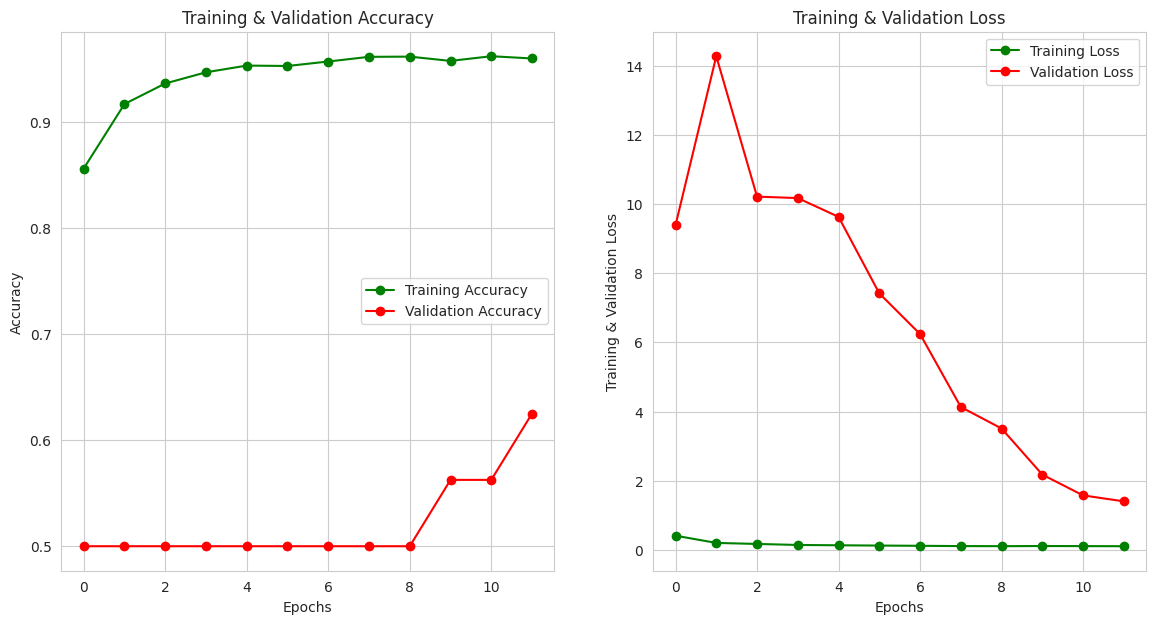

In [ ]:
acc_loss_visualize(history_5, num_epochs)

In [ ]:
predictions = (model_5_layers.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

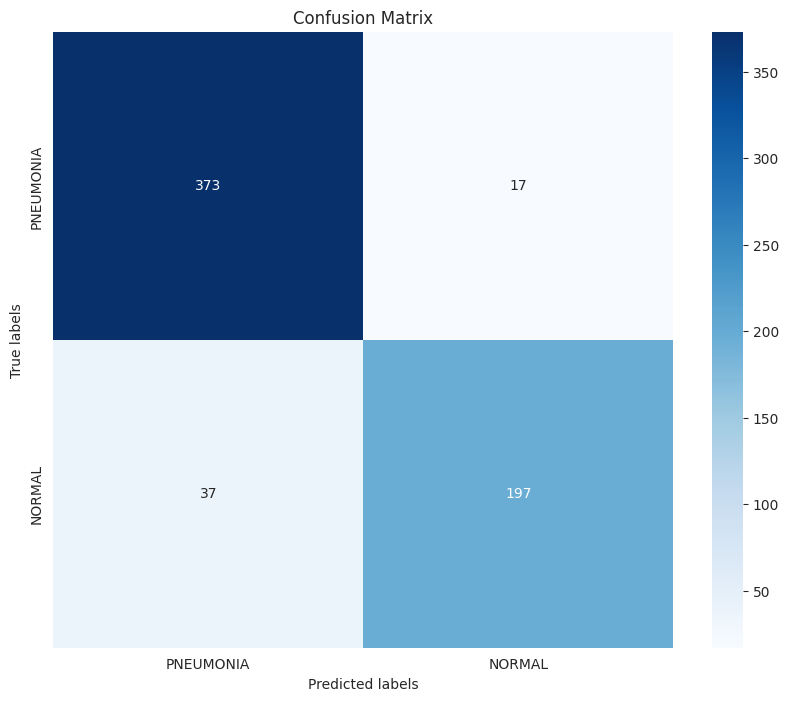

In [ ]:
conf_matrix_visualize(y_test, predictions)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

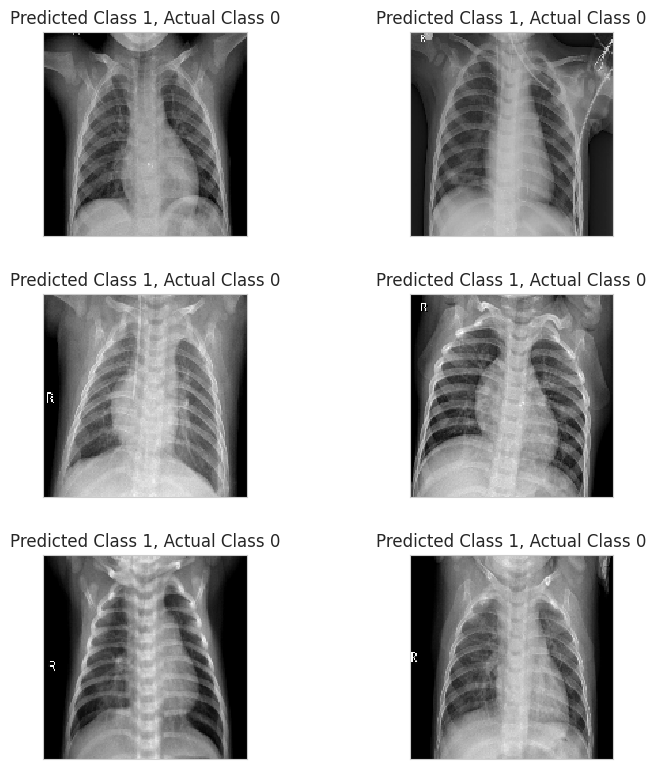

In [ ]:
# incorrect predictions
load_classified_img(incorrect, predictions, x_test, y_test)

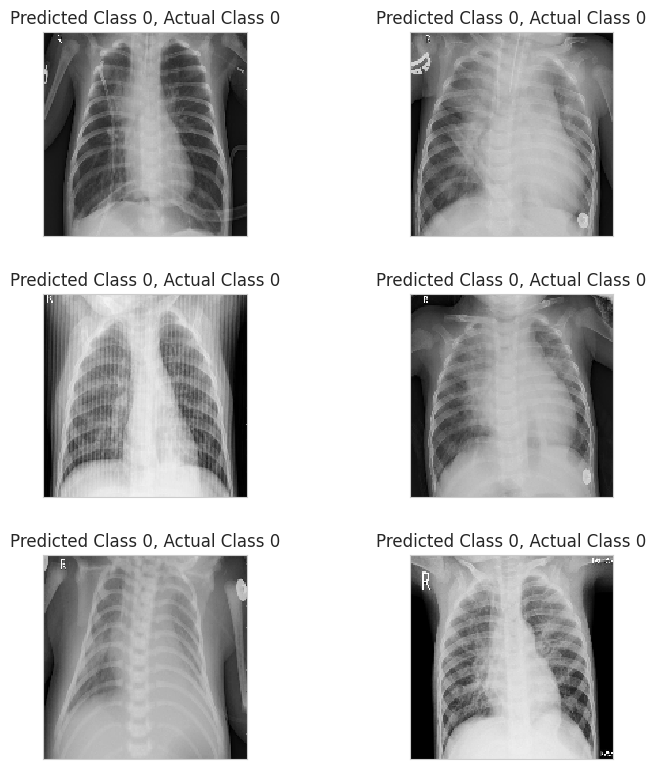

In [ ]:
# correct predictions
load_classified_img(correct, predictions, x_test, y_test)

### <font color ='black'>Pytorch</font>

#### <font color ='black'>Additional Data Processing</font>

In [ ]:
# paths to directories with label
train_label_dir = 'x-ray-pneumonia/chest_xray/train'
test_label_dir = 'x-ray-pneumonia/chest_xray/test'
val_label_dir = 'x-ray-pneumonia/chest_xray/val'

# paths to directories without label
train_dir = 'x-ray-pneumonia/chest_xray/train_no_label'
test_dir = 'x-ray-pneumonia/chest_xray/test_no_label'
val_dir = 'x-ray-pneumonia/chest_xray/val_no_label'

# paths to .csv files
train_csv = 'x-ray-pneumonia/chest_xray/train.csv'
test_csv = 'x-ray-pneumonia/chest_xray/test.csv'
val_csv = 'x-ray-pneumonia/chest_xray/val.csv'

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    x_train = []
    y_train = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))

                x_train.append(resized_arr)
                y_train.append(class_num)

            except Exception as e:
                pass

    return x_train, y_train

In [ ]:
x_train, y_train = get_training_data(train_label_dir)
x_train_np = np.array(x_train)
x_train_tensor = torch.tensor(x_train_np, dtype=torch.float32)

DATA_MEANS = (x_train_tensor / 255.0).mean(axis=(0,1,2))
DATA_STD = (x_train_tensor / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

In [ ]:
# From folder with label, create .csv file, where each line contains (image file name, label)
labels = ['PNEUMONIA', 'NORMAL']

def create_csv_file(data_dir, csv_file):

    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)

        for label in labels:
            path = os.path.join(data_dir, label) # train/PNEUMONIA
            class_num = labels.index(label) # 0

            for img in os.listdir(path):
                try:
                    img_path = os.path.join(path, img)
                    writer.writerow([img, class_num])

                except Exception as e:
                    pass

In [ ]:
create_csv_file(train_label_dir, train_csv)
create_csv_file(test_label_dir, test_csv)
create_csv_file(val_label_dir, val_csv)

#### <font color ='black'>Weighted Random Sampler</font>

In [ ]:
data = pd.read_csv(train_csv, header=None)

num_rows = len(data)
print(f"Number of rows in the CSV file: {num_rows}")

labels = data.iloc[:, 1].tolist()
len(labels)

In [ ]:
class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
print(class_sample_count)

weight = 1. / class_sample_count
print(weight)

In [ ]:
samples_weight = np.array([weight[t] for t in labels])
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

#### <font color ='black'>Custom dataset</font>

In [ ]:
class PneumoniaDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.metadata = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.metadata.iloc[idx, 0])

        if not os.path.isfile(img_name):
            raise FileNotFoundError(f"Image file not found: {img_name}")

        image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)  # numpy [H, W]
        image = torch.tensor(image, dtype=torch.float32)
        image = image.unsqueeze(0)  # [1, H, W]
        label = torch.tensor(self.metadata.iloc[idx, 1], dtype=torch.float32)

        if self.transform:
              image = self.transform(image)

        return image, label

In [ ]:
img_size = 150

# Define data augmentation transformations
train_transform = transforms.Compose([
    transforms.Resize(size=(img_size, img_size)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Normalize(DATA_MEANS, DATA_STD),
])

test_transform = transforms.Compose([
    transforms.Resize(size=(img_size, img_size)),
    transforms.Normalize(DATA_MEANS, DATA_STD),
])

In [ ]:
train_dataset = PneumoniaDataset(train_csv, train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)

test_dataset = PneumoniaDataset(test_csv, test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32)

val_dataset = PneumoniaDataset(val_csv, val_dir, transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=32)

#### <font color ='black'>Build model</font>

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Convolutional layer 1
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling layer 1

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Convolutional layer 2
        self.dropout1 = nn.Dropout2d(p=0.1)  # Dropout layer 1
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling layer 2

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)  # Convolutional layer 3
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization layer 3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling layer 3

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Convolutional layer 4
        self.dropout2 = nn.Dropout2d(p=0.2)  # Dropout layer 2
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization layer 4
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling layer 4

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # Convolutional layer 5
        self.dropout3 = nn.Dropout2d(p=0.2)  # Dropout layer 3
        self.bn5 = nn.BatchNorm2d(256)  # Batch normalization layer 5
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling layer 5

        self.fc1 = nn.Linear(256 * 4 * 4, 128)  # Fully connected layer 1
        self.dropout4 = nn.Dropout(p=0.2)  # Dropout layer 4
        self.fc2 = nn.Linear(128, 1)  # Output layer

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # Convolutional layer 1 + Batch normalization layer 1 + ReLU activation
        x = self.pool1(x)  # Max pooling layer 1
        x = F.relu(self.bn2(self.conv2(x)))  # Convolutional layer 2 + Batch normalization layer 2 + ReLU activation
        x = self.dropout1(x)  # Dropout layer 1
        x = self.pool2(x)  # Max pooling layer 2
        x = F.relu(self.bn3(self.conv3(x)))  # Convolutional layer 3 + Batch normalization layer 3 + ReLU activation
        x = self.pool3(x)  # Max pooling layer 3
        x = F.relu(self.bn4(self.conv4(x)))  # Convolutional layer 4 + Batch normalization layer 4 + ReLU activation
        x = self.dropout2(x)  # Dropout layer 2
        x = self.pool4(x)  # Max pooling layer 4
        x = F.relu(self.bn5(self.conv5(x)))  # Convolutional layer 5 + Batch normalization layer 5 + ReLU activation
        x = self.dropout3(x)  # Dropout layer 3
        x = self.pool5(x)  # Max pooling layer 5
        x = x.view(-1, 256 * 4 * 4)  # Flatten layer
        x = F.relu(self.fc1(x))  # Fully connected layer 1 + ReLU activation
        x = self.dropout4(x)  # Dropout layer 4
        x = torch.sigmoid(self.fc2(x))  # Output layer + Sigmoid activation
        return x

In [ ]:
# Instantiate the model
model = CNNModel()

torch_summary(model, (1, 1, 150, 150))

#### <font color ='black'>Train model</font>

In [ ]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the ReduceLROnPlateau scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=2, min_lr=0.000001, verbose=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 12

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    total_batches = 0
    total_class0 = 0
    total_class1 = 0

    for (inputs, labels) in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        predicted = (outputs > 0.5).int().squeeze()  # Convert probabilities to binary predictions
        train_correct += (predicted == labels).sum().item()

        total_batches += 1
        total_class0 += len(torch.where(labels == 0)[0])
        total_class1 += len(torch.where(labels == 1)[0])

    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_accuracy = train_correct / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    average_class0 = total_class0 / total_batches
    average_class1 = total_class1 / total_batches
    print("Average class 0: {:.2f}, Average class 1: {:.2f}".format(average_class0, average_class1))

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = (outputs > 0.5).int().squeeze()  # Convert probabilities to binary predictions
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_accuracy = val_correct / len(val_loader.dataset)

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2%}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2%}")

    # Update learning rate using ReduceLROnPlateau scheduler based on validation accuracy
    scheduler.step(val_epoch_loss)  # Pass validation loss as argument to scheduler

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### <font color ='black'>Evaluate model</font>

In [ ]:
# After training, evaluate the model on the test data
model.eval()
test_loss = 0.0
correct = 0
total = 0

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  # Assuming you have a DataLoader for the test data
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        test_loss += loss.item() * inputs.size(0)

        # Compute accuracy
        predicted = (outputs > 0.5).int().squeeze()  # Convert probabilities to binary predictions
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        print(f"correct / total: {correct} / {total}")

        all_predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

print("len(test_loader.dataset):", len(test_loader.dataset))

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct / len(test_loader.dataset)

print("Loss of the model is:", test_loss)
print("Accuracy of the model is:", test_accuracy)

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions))

In [ ]:
# Plot confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(all_labels, all_predictions)
print(conf_matrix)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## <font color ='purple'>Comparison and Conclusion</font>

- **Keras**:
    - Keras provides very intuitive classes and functions, from data processing to model training and evaluation.
    - Specifically, Keras code is simple and concise, but still able to build very good AI systems.
    - Therefore, it may be a very good framework to build fast demo or prototypes.
    - Keras can also be used to build industrial AI systems, since it requires minimal code but provides maximal functionalities.
- **PyTorch**:
    - PyTorch is faster than Keras.
    - Specifically, PyTorch works better with larger datasets and yields higher performance.
    - However, PyTorch code is more complex and requires understanding of data structure and the training process.
    - In return, PyTorch offers greater flexibility and allows developers to gain more insights into the entire workflow.
- **Conclusion**:
    - Our team are complete beginners to Keras and PyTorch. After this project, we have an impression that Keras implementation is fast and convenient, but PyTorch is definitely worth a try.
    - Specifically, the time we spend on PyTorch is roughly three times as much as the time we spend on Keras. At some points, we even think we would give up on the PyTorch version.
    - After successfully implementing PyTorch, we realize that PyTorch offers so much insights that Keras hides from us, although we literally implement the same idea using both frameworks.   
    - It does not mean we learn nothing from Keras. In fact, Keras helps us build the first successful model, and that is a very good foundation to start implementing the PyTorch version.
    - Afterall, we are grateful for this opportunity to learn and get familiar with Keras and PyTorch. We hope we could work in Machine Learning and Big Data later on in our careers, and Keras and PyTorch shall be our closed friends along the journey.